# Self-contained Example - Coupled nonlinear oscillators on Fashion MNIST

In this example, we consider a physical neural network based on coupled nonlinear oscillators. Here we consider an all-to-all connected coupled nonlinear oscillators that obeys the following equations of motion. 

$$ \frac{\mathrm{d}^2q_i}{\mathrm{d} t^2} = -\sin{q_i} + \sum_{j=1}^N J_{ij}\left( \sin{q_j} - \sin{q_i} \right) +e_i $$ 
where $q_i$ are the oscillator amplitudes, $J_{ij}$ are the coupling coefficients (which must be symmetric, i.e., $J_{ij}=J_{ji}$), and $e_i$ are individual oscillator drives. 

The oscillator system is turned into a PNN by the following input-output map. We encode the data into the initial amplitudes, and the output is taken to be state of the oscillator after some time-evolution.  Because this is a second order ODE, the first derivatives are set to 0, so the system begins at rest $\dot q_i (t=0) = 0$.

In this notebook, we show such a PNN can be trained to perform the Fashion MNIST task. 

In order to simulate the effect of the mismatch between model and experiment that is addressed by physics-aware training, we add noise to (a) the nonlinearity coefficient, and (b) the coupling coefficients J_ij. Thus, while the model remains described by the equation above, the physical system is described by:
$$    \frac{\mathrm{d}^2q_i}{\mathrm{d} t^2} = -\sin({(1+\eta)q_i}) + \sum_{j=1}^N (J_{ij}+J^{\mathrm{noise}}_{ij})\left( \sin({(1+\eta)q_j}) - \sin({(1+\eta) q_i}) \right) +e_i $$

The architecture we consider for this PNN is as follows - see caption for detail.
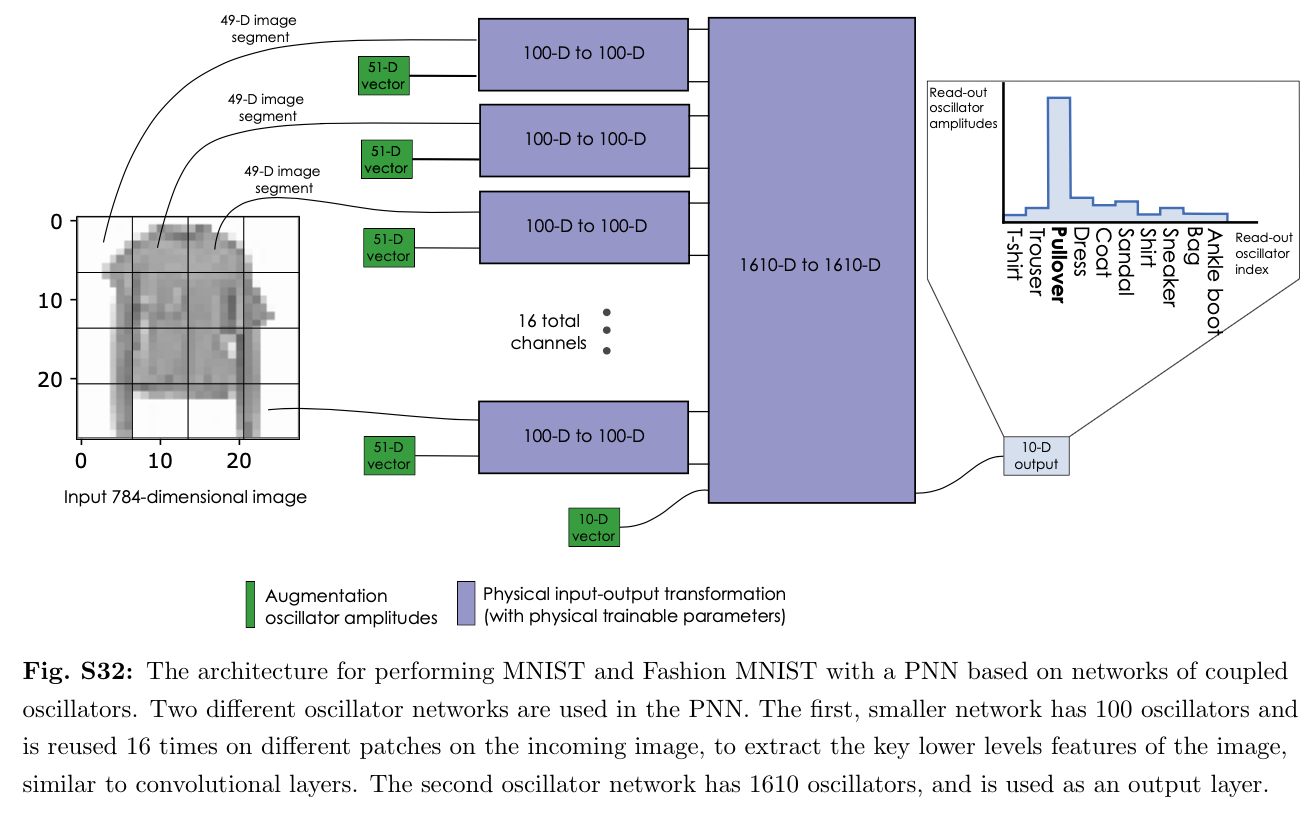

## Loading the Fashion MNIST dataset

In [1]:
batch_size = 32
from torchvision.datasets import FashionMNIST
import torch
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader
compress_factor = 1
reshape_f = lambda x: torch.reshape(x[0, ::compress_factor, ::compress_factor], (-1, ))
transform = transforms.Compose([transforms.ToTensor()])

In [2]:
transform_noise = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor()])

transform_val = transforms.Compose([transforms.ToTensor()])

train_set = (FashionMNIST(
    root = '../..',
    train = True,
    download = True,
    transform = transform_noise
))

val_set = (FashionMNIST(
    root = '../..',
    train = False,
    download = True,
    transform = transform_val
))

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

/usr/local/anaconda/envs/NN_v2/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Plotting an example fashion MNIST image and its associated label

'T-shirt'

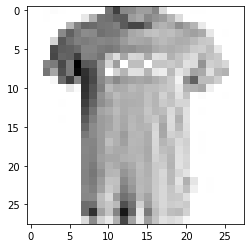

In [3]:
import matplotlib.pylab as plt

torch.manual_seed(0)
x, y = next(iter(train_loader))

labels = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", 
          "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

ind = 3

plt.imshow(x[ind].reshape(28, 28), cmap="binary")

labels[y[ind]]

### Parameters of the architecture and simulation

In [4]:
device = 0 #gpu number, use "cpu" if running on CPU

#parameters associated with the architecture
image_size = 28
patch_size = 7
dim = 100
num_patches = (image_size // patch_size) ** 2

#parameters associated with noise
noise = 0.2
η = 0.1
stochastic_noise = 0.02

#parameters associated with the ODE solver
Nt = 5
tend = 0.5
dt = tend/Nt

## Defining the differential equation and utility functions for solving them

In [5]:
#Generate code for solving ODEs with RK4
def rk_loop(f, x, h, *args):
    k1 = f(x, *args)
    k2 = f(x+h*k1/2, *args)
    k3 = f(x+h*k2/2, *args)
    k4 = f(x+h*k3, *args)
    return x + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def make_ode_map(f):
    def ode_map(x, *args):
        for i in range(Nt):
            x = rk_loop(f, x, dt, *args)
        return x  
    return ode_map

#set of ODEs that we consider in the numerical experiment
def ode(z, Jmat, Jbias):
    q = z[..., 0]
    p = z[..., 1]
    output = torch.empty_like(z)
    output[..., 0] = p
    sin_q = torch.sin(q)
    output[..., 1] = -sin_q + Jbias + sin_q@Jmat
    return  output

def ode_conv_exp(z, Jmat, Jbias):
    q = z[..., 0]
    p = z[..., 1]
    output = torch.empty_like(z)
    output[..., 0] = p
    sin_q = torch.sin((1+η)*q)
    output[..., 1] = -sin_q + Jbias + sin_q@Jmat + sin_q@J_conv_noise
    return  output

def ode_fc_exp(z, Jmat, Jbias):
    q = z[..., 0]
    p = z[..., 1]
    output = torch.empty_like(z)
    output[..., 0] = p
    sin_q = torch.sin((1+η)*q)
    output[..., 1] = -sin_q + Jbias + sin_q@Jmat + sin_q@J_fc_noise
    return  output

#function to generate the input noise of setting the initial oscillator amplitudes
def make_noise(x):
    n_tensor = torch.zeros_like(x)
    n_tensor[..., 0] = stochastic_noise*torch.randn(x.shape[:-1])
    return n_tensor

#defining an effective J matrix to speed up the computation
def symmetrize_J(J):
    J = (J + J.T)/2
    Jcolsum = -torch.sum(J, axis=0)
    inds = list(range(J.shape[0]))
    J[inds, inds] = Jcolsum
    return J

#passing this symmetrization operation to the ODE solver
def make_f_sym(f):
    def f_symJ(x, Jmat, *args):
        J_sym = symmetrize_J(Jmat)
        return f(x, J_sym, *args)
    return f_symJ

f_model = make_f_sym(make_ode_map(ode))
f_conv_pre = make_f_sym(make_ode_map(ode_conv_exp))
f_fc_pre = make_f_sym(make_ode_map(ode_fc_exp))

#the following functions are meant to model a forward pass that cannot be backproped through
#, necessitating a PAT approach.
def f_conv_exp(*args):
    with torch.no_grad():
        return f_conv_pre(*args)
    
def f_fc_exp(*args):
    with torch.no_grad():
        return f_fc_pre(*args)

#this code is used to define the PAT function
def generate_func(forward_f, backward_f):
    class func(torch.autograd.Function):
        @staticmethod
        def forward(ctx, *args): 
            ctx.save_for_backward(*args)
            return forward_f(*args)
        def backward(ctx, grad_output):
            args = ctx.saved_tensors
            torch.set_grad_enabled(True)
            y = torch.autograd.functional.vjp(backward_f, args, v=grad_output)
            torch.set_grad_enabled(False)
            return y[1]
    return func.apply

f_conv_pat = generate_func(f_conv_exp, f_model)
f_fc_pat = generate_func(f_fc_exp, f_model)

# Define the noise coupling matrices
torch.manual_seed(0)
J_conv_noise = symmetrize_J(noise*torch.randn(dim, dim)).to(device)
J_fc_noise = symmetrize_J(noise*torch.randn(dim*num_patches+10, dim*num_patches+10)).to(device)

## General trainer code
This code uses [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning) to perform the training. The following code defines a pytorch lightning module that effectively allows us to obtain a full training loop with logging and other convenient functionalities. 

In [6]:
import pytorch_lightning as pl
from pytorch_lightning.metrics import Accuracy

class ClassificationPlModel(pl.LightningModule):
    """
    Classifies the usual way where the cross entropy loss is used!
    """
    def __init__(self):
        super().__init__()
        self.accu_metric = Accuracy()
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = F.cross_entropy(out, y) 
        y_pred = torch.max(out, 1)[1]
        accuracy = self.accu_metric(y_pred, y)

        result = pl.TrainResult(loss)
        result.log('train_loss', torch.sqrt(loss))
        result.log('train_accu', accuracy)
        return result
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = F.cross_entropy(out, y) 
        y_pred = torch.max(out, 1)[1]
        accuracy = self.accu_metric(y_pred, y)

        result = pl.EvalResult(checkpoint_on=accuracy)
        result.log('val_loss', loss)
        result.log('val_accu', accuracy)
        return result
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = F.cross_entropy(out, y) 
        y_pred = torch.max(out, 1)[1]
        accuracy = self.accu_metric(y_pred, y)

        result = pl.EvalResult(checkpoint_on=loss)
        return result

### Defining the model

In [7]:
from einops.layers.torch import Rearrange, Reduce
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class MLP(ClassificationPlModel):
    def __init__(self, f_conv, f_fc):
        super().__init__()
        self.rearrange = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', 
                              p1 = patch_size, p2 = patch_size)
        self.fc1 = nn.Linear(dim, dim)
        self.fc2 = nn.Linear(dim*num_patches+10, dim*num_patches+10)
        self.output_fac = nn.Parameter(torch.tensor(1.0).float())
        self.f_conv = f_conv
        self.f_fc = f_fc
        
    def forward(self, x):
        x = self.rearrange(x)
        x = torch.stack([x, torch.zeros_like(x)], dim=-1)
        x = torch.cat([x, torch.zeros([*x.shape[:-2], dim-patch_size**2, 2]
                                      , device=x.device)], dim=-2)
        
        #right before it goes into f_conv...
        x += make_noise(x)
        x = self.f_conv(x, *self.fc1.parameters())
        x = x[..., 0]
        x = x.view(x.size(0), -1)
        
        x = torch.stack([x, torch.zeros_like(x)], dim=2)
        x = torch.cat([x, torch.zeros([x.shape[0], 10, 2], device=x.device)], dim=1)
        
        x += make_noise(x)
        x = self.f_fc(x, *self.fc2.parameters())
        
        x = self.output_fac*(x[:, -10:, 0])
        return x
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters())
        return optimizer

In [8]:
model = MLP(f_conv_pat, f_fc_pat).to(device)

In [9]:
#check that the module does run
x, y = next(iter(train_loader))
model(x.to(device)).shape

torch.Size([32, 10])

### Training configuration
The training for this model takes about 90 minutes on a GPU. If the user wants the skip the training and load the trained model - please skip these cells and run the cells in the next section.

In [35]:
#defines where the training curve is saved + where the model is saved
import os 
log_dir = "precomputed_results"
logger = pl.loggers.CSVLogger(log_dir, "Example3", "trial3")

max_epochs = 30

In [36]:
checkpoint_file = os.path.join(log_dir, "Example3", "trial3", "{epoch}-{val_accu:.2f}")
checkpoint_cb = pl.callbacks.ModelCheckpoint(checkpoint_file, mode="max")

In [37]:
if device != "cpu":
    trainer = pl.Trainer(max_epochs=max_epochs, logger=logger, gpus=[device],
                            log_save_interval=50, row_log_interval=4, val_check_interval=0.2,
                            checkpoint_callback=checkpoint_cb, 
                            weights_summary=None, progress_bar_refresh_rate=0)
else:
    trainer = pl.Trainer(max_epochs=max_epochs, logger=logger,
                            log_save_interval=50, row_log_interval=4, val_check_interval=0.2,
                            checkpoint_callback=checkpoint_cb, 
                            weights_summary=None, progress_bar_refresh_rate=0)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [ ]:
trainer.fit(model, train_loader, val_loader)

## Visualize results

### Load the training cuve and the trained parameters

In [11]:
import os
import glob
#load the parameters of the model
data_dir = "precomputed_results/Example3/trial3"

ckpt = glob.glob(os.path.join(data_dir,'*.ckpt'))[0]

if device != "cpu":
    save_dict = torch.load(ckpt, map_location=f"cuda:{device}")
else: 
    save_dict = torch.load(ckpt, map_location="cpu")
state_dict = save_dict["state_dict"]
state_dict.keys()

model = MLP(f_conv_pat, f_fc_pat).to(device)

model.load_state_dict(state_dict)

<All keys matched successfully>

### Plot the trained coupling matrices and internal dynamics present in the oscillator network

Text(0.5, 1.0, '$e_{i}$ of first oscillator network')

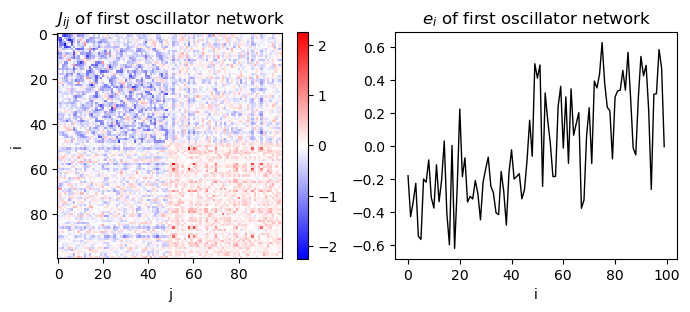

In [22]:
J_conv = symmetrize_J(state_dict["fc1.weight"])
e_conv = state_dict["fc1.bias"]

J = J_conv
e = e_conv
J_offdiag = J.clone()

for i in range(J_offdiag.shape[0]):
    J_offdiag[i,i]=0.0
J_conv_offdiag = J_offdiag.clone()

fig, axs = plt.subplots(1, 2, figsize=(8, 3), dpi=100)

plt.sca(axs[0])
vmax = torch.max(torch.abs(J_offdiag)).cpu()
plt.imshow((J_offdiag.cpu()), vmax=vmax, vmin=-vmax, cmap="bwr", interpolation="nearest")
plt.colorbar()
plt.ylabel("i")
plt.xlabel("j")
plt.title(r"$J_{ij}$ of first oscillator network")

plt.sca(axs[1])
plt.plot(e.cpu(), "k", lw=1)
plt.xlabel("i")
plt.title(r"$e_{i}$ of first oscillator network")

Text(0.5, 1.0, '$e_{i}$ of second oscillator network')

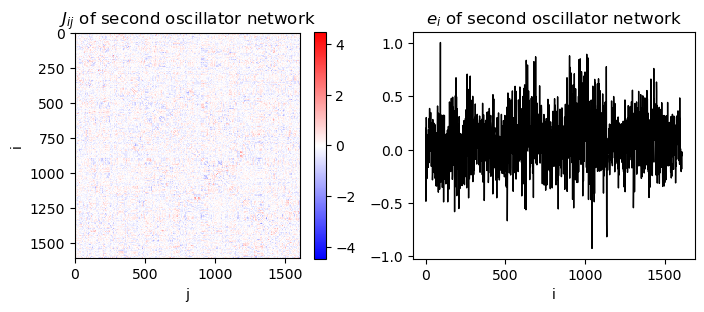

In [24]:
J_fc = symmetrize_J(state_dict["fc2.weight"])
e_fc = state_dict["fc2.bias"]

J = J_fc
e = e_fc
J_offdiag = J.clone()
J_fc_offdiag = J_offdiag.clone()

for i in range(J_offdiag.shape[0]):
    J_offdiag[i,i]=0.0

fig, axs = plt.subplots(1, 2, figsize=(8, 3), dpi=100)

plt.sca(axs[0])
vmax = torch.max(torch.abs(J_offdiag)).cpu()
plt.imshow((J_offdiag).cpu(), vmax=vmax, vmin=-vmax, cmap="bwr", interpolation="nearest")
plt.colorbar()
plt.ylabel("i")
plt.xlabel("j")
plt.title(r"$J_{ij}$ of second oscillator network")

plt.sca(axs[1])
plt.plot(e.cpu(), "k", lw=1)
plt.xlabel("i")
plt.title(r"$e_{i}$ of second oscillator network")

In [25]:
Nt = 100
tend = 0.5
dt = tend/Nt

0 T-shirt


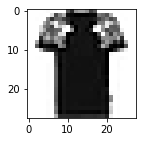

In [32]:
import numpy as np
import matplotlib.cm as cm

torch.manual_seed(4)
x, y = next(iter(val_loader))

plt.figure(figsize=(2,2))
ind = 4
img = x[ind, :].numpy()
target = y[ind].numpy()
print(target, labels[target])

plt.imshow(img[0], cmap="binary");


self = model.to(device)
x = x.to(device)

x = self.rearrange(x)
x = torch.stack([x, torch.zeros_like(x)], dim=-1)
x = torch.cat([x, torch.zeros([*x.shape[:-2], dim-patch_size**2, 2]
                              , device=x.device)], dim=-2)
x += make_noise(x)

tlist = np.linspace(0, tend, Nt)
xlist = torch.empty([Nt, *x.shape])

with torch.no_grad():
    for i in range(Nt):
        x = rk_loop(ode_conv_exp, x, dt, J_conv, e_conv)
        xlist[i] = x

x = x[..., 0]
x = x.view(x.size(0), -1)

x = torch.stack([x, torch.zeros_like(x)], dim=2)
x = torch.cat([x, torch.zeros([x.shape[0], 10, 2], device=x.device)], dim=1)
x += make_noise(x)

tlist = np.linspace(0, tend, Nt)
xlist = torch.empty([Nt, *x.shape])

with torch.no_grad():
    for i in range(Nt):
        x = rk_loop(ode_fc_exp, x, dt, J_fc, e_fc)
        xlist[i] = x

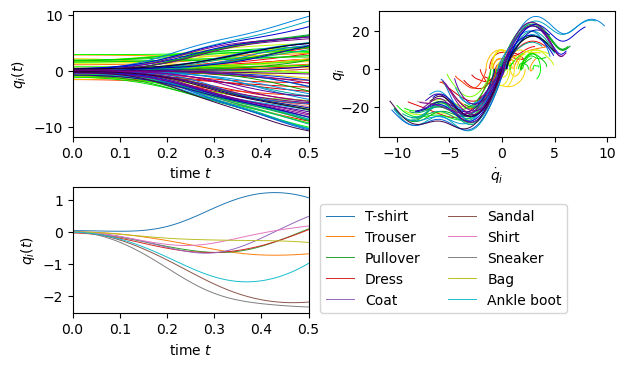

In [33]:
# cmap = cm.gist_rainbow_r
cmap = cm.nipy_spectral_r

fig, axs = plt.subplots(2, 2, figsize=(7, 4), dpi=100)

fig.subplots_adjust(hspace=0.4, wspace=0.3)
for osc_ind in range(100):
    q = [x[ind, osc_ind, 0] for x in xlist]
    p = [x[ind, osc_ind, 1] for x in xlist]
    
    plt.sca(axs[0,0])
    plt.plot(tlist, q, color=cmap(osc_ind/100), lw=0.7)
    plt.xlabel(r"time $t$")
    plt.ylabel(r"$q_i(t)$")
    plt.xlim(0, 0.5)
    
    plt.sca(axs[0,1])
    plt.plot(q, p, color=cmap(osc_ind/100), lw=0.7)
    plt.ylabel(r"$q_i$", labelpad=-5)
    plt.xlabel(r"$\dot q_i$")

cmap = cm.tab10

plt.sca(axs[1,0])
for (i, traj) in enumerate(xlist[:, ind, -10:, 0].T):
    plt.plot(tlist, traj, color=cmap(i/10), label=f"{labels[i]}", lw=0.7)
plt.legend(loc=(1.05, 0.0), ncol=2)
plt.xlabel(r"time $t$")
plt.ylabel(r"$q_i(t)$")
plt.xlim(0, 0.5)

plt.sca(axs[1,1])
plt.axis("off");

### Plot the training curve and confusion matrix

In [37]:
#load the training curve
import pandas as pd
df = pd.read_csv(os.path.join(data_dir, "metrics.csv"))
mask = [not(x) for x in np.isnan(df["val_accu"].values)]
epoch = df["epoch"].values[mask]
accu = df["val_accu"].values[mask]
epoch = epoch[::5]
accu = accu[::5]

In [38]:
#The following are plotting utility functions to make the plots in the supplementary material
#Not necessary, can use simpler plotting code if desired
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sklearn.metrics as metrics
from itertools import product
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

class ConfusionMatrixDisplay:
    #porting and editting code from scipy's ConfusionMatrixDisplay
    def __init__(self, confusion_matrix, display_labels):
        self.confusion_matrix = confusion_matrix
        self.display_labels = display_labels
    def plot(self, include_values=True, cmap='viridis',
             xticks_rotation='horizontal', values_format=None, ax=None, fontsize=10):
        import matplotlib.pyplot as plt
        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.figure
        cm = self.confusion_matrix
        n_classes = cm.shape[0]
        self.im_ = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        self.text_ = None
        cmap_min, cmap_max = self.im_.cmap(0), self.im_.cmap(256)
        if include_values:
            self.text_ = np.empty_like(cm, dtype=object)
            if values_format is None:
                values_format = '.2g'
            # print text with appropriate color depending on background
            for i, j in product(range(n_classes), range(n_classes)):
                self.text_[i, j] = ax.text(j, i,
                                           format(cm[i, j], values_format),
                                           ha="center", va="center",
                                           color="k", fontsize=fontsize)
        ax.set(xticks=np.arange(n_classes),
               yticks=np.arange(n_classes),
               xticklabels=self.display_labels,
               yticklabels=self.display_labels,
               ylabel="True label",
               xlabel="Predicted label")
        ax.set_ylim((n_classes - 0.5, -0.5))
        plt.setp(ax.get_xticklabels(), rotation=xticks_rotation)
        self.figure_ = fig
        self.ax_ = ax
        return self

color_pat = np.array([17, 74, 189])/255
white = [1, 1, 1] #rgb values for white
marker_pat = "o"

def plot_dots_v2(x, y, marker, color, **kwargs):
    color_f = make_rgb_transparent(color, white, 0.3)
    plt.plot(x, y, "--", marker=marker, mec=color, mfc=color_f, markersize=5, markeredgewidth=0.7, lw=0.5, color=color, **kwargs)

def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2
            for (c1, c2) in zip(rgb, bg_rgb)]

In [39]:
#the following code runs the trained model on examples from the validation set
#to construct a confusion matrix
torch.manual_seed(0)
x = []
y = []
for xi, yi in list(val_loader):
    x.append(xi)
    y.append(yi)

x = torch.cat(x, dim = 0).to(device)
print(x.shape)
target = torch.cat(y, dim = 0)

with torch.no_grad():
    out = model(x)

pred = torch.max(out, 1)[1].cpu()

Ndig = 100
target_eq=list()
pred_eq=list()
count = np.zeros(10)
for idx in range(len(pred)):
    ti=target[idx]
    yi=pred[idx]
    count[ti]+=1
    if count[ti]<=Ndig:
        target_eq.append(ti)
        pred_eq.append(yi)
conf = metrics.confusion_matrix(target_eq, pred_eq)

torch.Size([10000, 1, 28, 28])


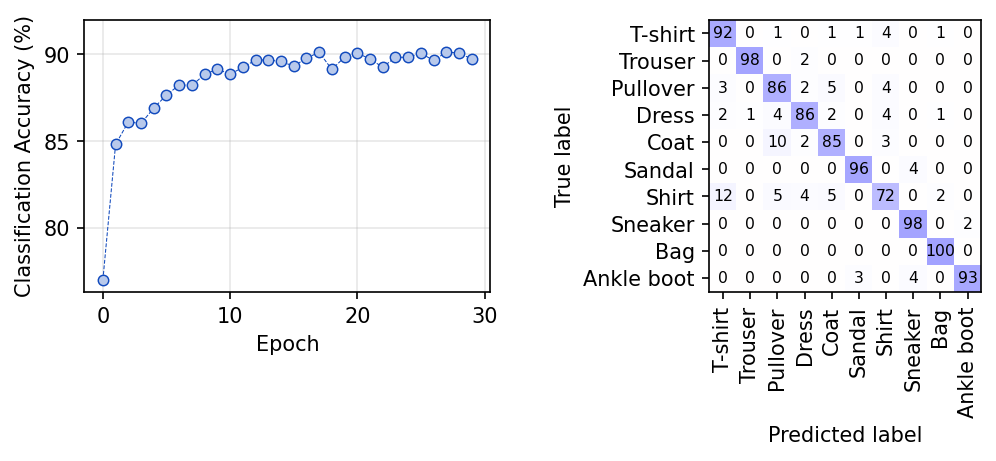

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2.4), 
                    gridspec_kw=dict(width_ratios=[0.6, 0.5]), dpi=150)

fig.subplots_adjust(wspace=0.5)
plt.sca(axs[0])
plot_dots_v2(epoch, accu*100, marker_pat, color_pat, label="Physics-Aware Training")
plt.grid(alpha=0.3)
plt.ylim(top=92)

plt.xlabel("Epoch")
plt.ylabel("Classification Accuracy (%)")

plt.sca(axs[1])
cmap = cm.get_cmap('bwr', 512)
custom_cmap = ListedColormap(cmap(np.linspace(0.5, 0.32, 256)))
disp = ConfusionMatrixDisplay(conf, labels)
size = 1
disp.plot(cmap=custom_cmap, ax=plt.gca(), values_format="d", fontsize=7.5, xticks_rotation='vertical')